<a href="https://colab.research.google.com/github/Deanelle/Anime-Recommendation-System-/blob/main/Content_Based_Anime_Remmendation_System_with_K_Nearest_Neighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Context**
Over the past few years fandom for the anime industry has increased in the United States. With the advent of covid and with more people spending more time indoors, there is a need to be able to find and watch entertaining anime. However, there are tons of options and if you are like, those options can be overwhelming and act as a deterent to watching the anime that you love. 

 Wtih there being thousands of good anime it gets increasingly difficult to choose and thus more easy for choice paralysis to kick in. **Therefore, with this project, I am designing a  content-based recommendation system that can help anyone view the types of anime that they enjoy or any company recommend to viewers they anime that they will be more inclined to watch.**

**About the Data**
The data comes from MyAnimeList and I downloaded the anime.csv file from Kaggle and it contains information on user preference data from 73,516 users on 12.294 anime. Each user was able to add anime to their completed list and give it a rating and this data is a compilation of those ratings. 

**The content:**

*Anime.csv* 

- anime_id: myanimelist.net's unique id identifying an anime.
- name: full name of anime 
- genre: comma separated list of genres for this anime. 
- type: movie, TV,OVa, etc. 
- episodes: how many episodes in this show. (1 if movie). 
- rating: average rating out of 10 for this anime. 
- members: number of commuinity members that are in thsi anime's "group". 


*Rating.csv*
- user_id: non-identifiable randomly generated user-id
- anime_id: the anime that the user has rated 
- rating: rating out of 10 this user has assigned (-1 if the user watched it but didn’t assign a rating)


Since I only looked at the content based features, I chose to only focus on the anime.csv dataframe and not the rating.csv since I was not looking at the user interaction features. 


1. Import the libaries and load the dataset. I decided to use a K Nearest Neighbors for this dataset. :

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import re 
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



In [ ]:
anime= pd.read_csv("anime.csv")

In [ ]:
anime.shape

(12294, 7)

In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [ ]:
anime.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


In [ ]:
anime.tail(10)

,anime_id,name,genre,type,episodes,rating,members
12284,26031,Super Erotic Anime,Hentai,OVA,2,4.45,118
12285,34399,Taimanin Asagi 3,"Demons, Hentai, Supernatural",OVA,Unknown,NaN,485
12286,10368,Teleclub no Himitsu,Hentai,OVA,2,4.67,148
12287,9352,Tenshi no Habataki Jun,Hentai,OVA,1,4.33,201
12288,5541,The Satisfaction,Hentai,OVA,1,4.37,166
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175
12293,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,Movie,1,5.46,142


After checking the head and tail of the data, I osberved that there are nan values in rating and there are unknown values in the episodes column that I'll deal with in preprocessing. 

In [ ]:
anime.rating.min()

1.67

In [ ]:
anime.rating.max()

10.0

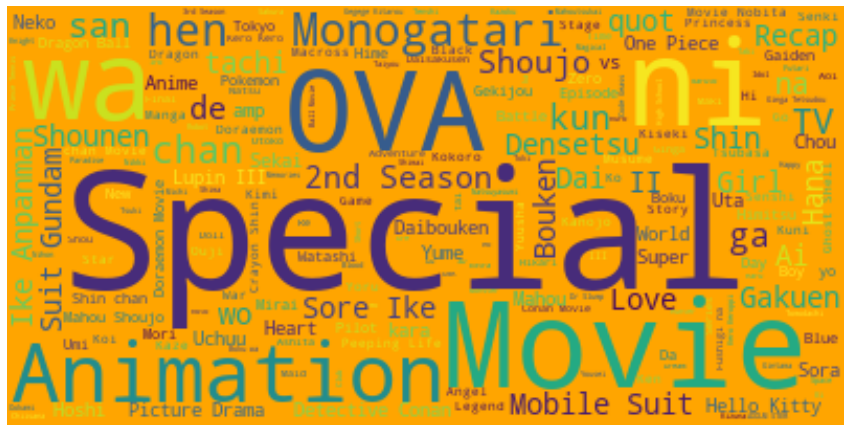

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="orange").generate(" ".join(anime["name"]))
plt.figure(figsize=(15,10))
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

In [ ]:
type = anime['type'].value_counts()
print(type)

TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: type, dtype: int64


Cleaning the data. 

In [ ]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

There are null values in genre, rating, and type. 


In [ ]:
anime.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

**Feature Engineering**

In [ ]:
anime[anime['episodes']=='Unknown'].head(3)

,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862
252,235,Detective Conan,"Adventure, Comedy, Mystery, Police, Shounen",TV,Unknown,8.25,114702
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,Unknown,7.94,533578


Earlier I noticed that there was an unknown value in the episodes column so I decided to take a look at that column a little more closerly. I looked at a few of the anime that had an unknown amount of episodes and figured that their episodes are unknown because these series, One Piece, Naruto, Dective Conan are still ongoing. 

In [ ]:
anime.loc[(anime["genre"]=="Hentai") & (anime["episodes"]=="Unknown"),"episodes"] = "1"
anime.loc[(anime["type"]=="OVA") & (anime["episodes"]=="Unknown"),"episodes"] = "1"

anime.loc[(anime["type"] == "Movie") & (anime["episodes"] == "Unknown")] = "1"

For Hentai,OVA, and Movies I filled the episodes with 1 since these types of anime are usually one episode or showing. 

In [ ]:
known_animes = {"Naruto Shippuuden":500, "One Piece":784,"Detective Conan":854, "Dragon Ball Super":86,
                "Crayon Shin chan":942, "Yu Gi Oh Arc V":148,"Shingeki no Kyojin Season 2":25,
                "Boku no Hero Academia 2nd Season":25,"Little Witch Academia TV":25}

In [ ]:
for k,v in known_animes.items():    
    anime.loc[anime["name"]==k,"episodes"] = v

In [ ]:
anime["episodes"] = anime["episodes"].map(lambda x:np.nan if x=="Unknown" else x)

In [ ]:
anime["episodes"].fillna(anime["episodes"].median(),inplace = True)


I filled any nan values with the median here. 

In [ ]:
#one hot encoding 
pd_type = pd.get_dummies(anime[["type"]])
pd_type.head()

,type_1,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV
0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


In [ ]:
anime['members']=anime['members'].astype(float)

In [ ]:
anime['members']

0        200630.0
1        793665.0
2        114262.0
3        673572.0
4        151266.0
           ...   
12289       211.0
12290       183.0
12291       219.0
12292       175.0
12293       142.0
Name: members, Length: 12294, dtype: float64

In [ ]:
anime["rating"] = anime["rating"].astype(float)
anime["rating"].fillna(anime["rating"].median(),inplace = True)

In [ ]:
# Scaling

anime_features = pd.concat([anime["genre"].str.get_dummies(sep=","),
                            pd.get_dummies(anime[["type"]]),
                            anime[["rating"]],anime[["members"]],anime["episodes"]],axis=1)

In [ ]:
anime["name"] = anime["name"].map(lambda name:re.sub('[^A-Za-z0-9]+', " ", name))

For members feature, I  converted the strings to float.

Episode numbers, members and rating are different from categorical variables and very different in values. 

Since rating ranges from 0-10 and the episode number can be even 800+ episodes long when it comes to long running popular animes such as One Piece, Detective Conan, etc... 

 I used the sklearn.preprocessing.MinMaxScaler to scale the values from 0-1.

I filled any unknown ratings with the median of the ratings.

In [ ]:
anime_features.head()

,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,...,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,type_1,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,rating,members,episodes
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9.37,200630.0,1
1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9.26,793665.0,64
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9.25,114262.0,51
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9.17,673572.0,24
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9.16,151266.0,51


Data exploration. Looking at my distributions. 

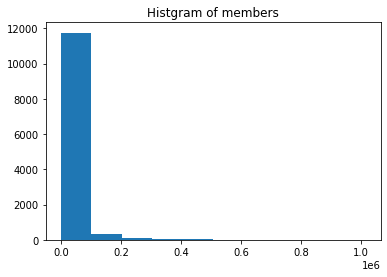

In [ ]:
plt.hist(anime['members'])
plt.title("Histgram of members")
plt.show()

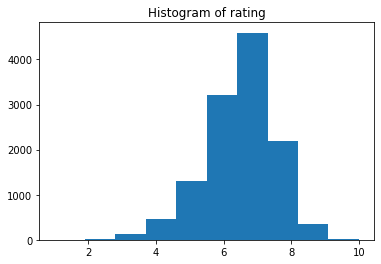

In [ ]:
plt.hist(anime["rating"])
plt.title("Histogram of rating")
plt.show()

It seems like the mean is around 6 and 7 for the ratings. 

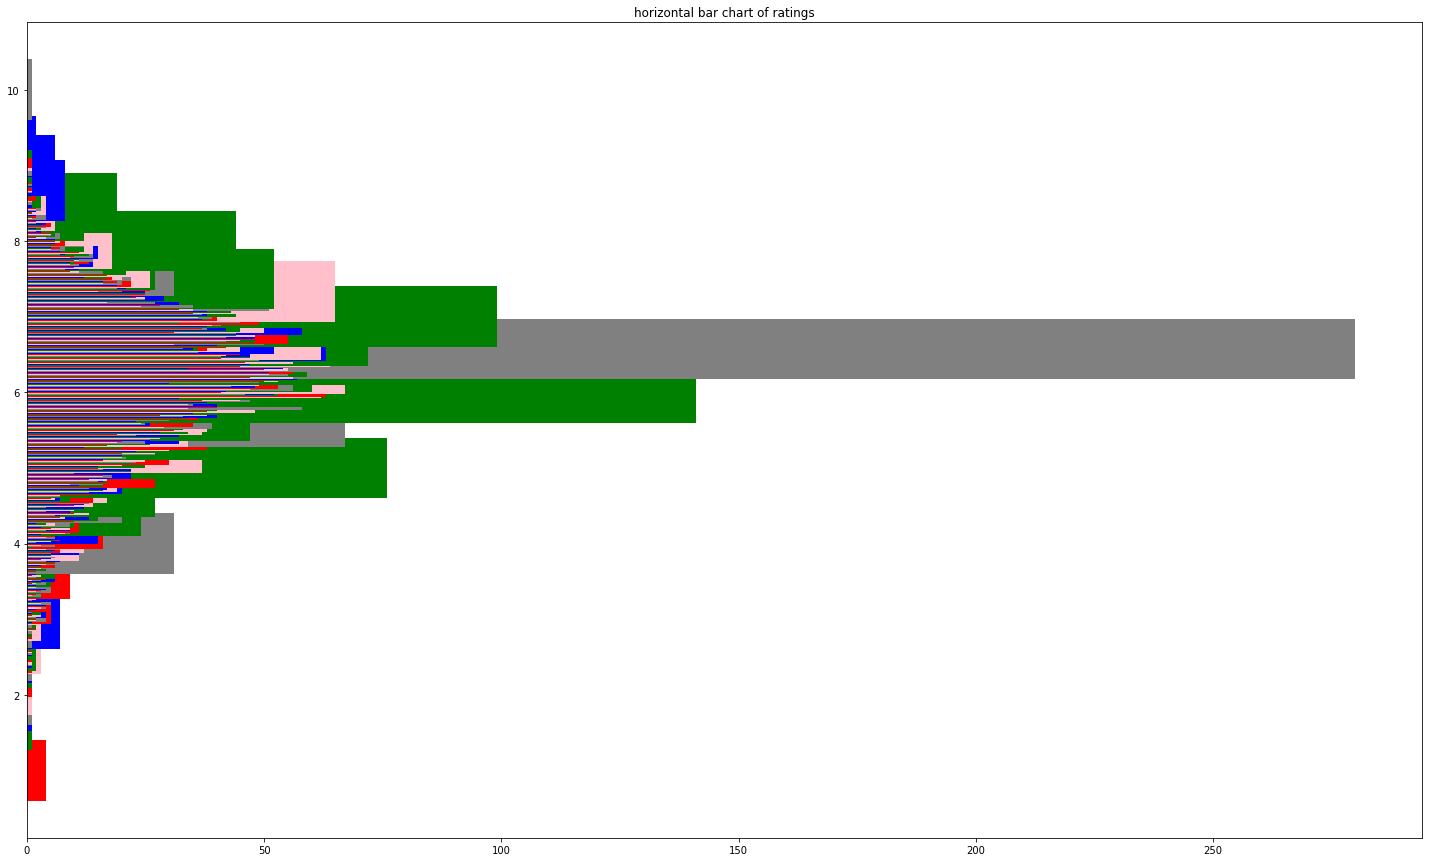

In [ ]:
plt.figure(figsize=(25,15))
plt.barh(anime.groupby("rating")["rating"].count().index, 
        anime.groupby("rating")["rating"].count(), 
        color=["red","green","blue","grey","pink"])
plt.title("horizontal bar chart of ratings")

plt.show()

In [ ]:
anime_features.columns

Index([' Adventure', ' Cars', ' Comedy', ' Dementia', ' Demons', ' Drama',
       ' Ecchi', ' Fantasy', ' Game', ' Harem', ' Hentai', ' Historical',
       ' Horror', ' Josei', ' Kids', ' Magic', ' Martial Arts', ' Mecha',
       ' Military', ' Music', ' Mystery', ' Parody', ' Police',
       ' Psychological', ' Romance', ' Samurai', ' School', ' Sci-Fi',
       ' Seinen', ' Shoujo', ' Shoujo Ai', ' Shounen', ' Shounen Ai',
       ' Slice of Life', ' Space', ' Sports', ' Super Power', ' Supernatural',
       ' Thriller', ' Vampire', ' Yaoi', ' Yuri', '1', 'Action', 'Adventure',
       'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy',
       'Game', 'Harem', 'Hentai', 'Historical', 'Horror', 'Josei', 'Kids',
       'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music', 'Mystery',
       'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School',
       'Sci-Fi', 'Seinen', 'Shoujo', 'Shounen', 'Slice of Life', 'Space',
       'Sports', 'Super Power', 'Supernat

**K-Nearest Neighbors**

In [ ]:
min_max_scaler=MinMaxScaler()

In [ ]:
anime_features=min_max_scaler.fit_transform(anime_features)

In [ ]:
np.round(anime_features,2)

array([[0.  , 0.  , 0.  , ..., 0.93, 0.2 , 0.  ],
       [1.  , 0.  , 0.  , ..., 0.92, 0.78, 0.03],
       [0.  , 0.  , 1.  , ..., 0.92, 0.11, 0.03],
       ...,
       [0.  , 0.  , 0.  , ..., 0.43, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.44, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.5 , 0.  , 0.  ]])

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
nbrs=NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(anime_features)

In [ ]:
distanes, indices =nbrs.kneighbors(anime_features)

Query Examples for the Recommender: 

In [ ]:
def get_index_from_name(name):
    return anime[anime["name"]==name].index.tolist()[0]

In [ ]:
all_anime_names = list(anime.name.values)

In [ ]:
def get_id_from_partial_name(partial):
    for name in all_anime_names:
        if partial in name:
            print(name,all_anime_names.index(name))

In [ ]:

""" print_similar_query can search for similar animes both by id and by name. """

def print_similar_animes(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(anime.loc[id]["name"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(anime.loc[id]["name"])

In [ ]:
print_similar_animes(query='Naruto')



Naruto Shippuuden
Katekyo Hitman Reborn 
Bleach
Dragon Ball Z
Boku no Hero Academia


This query returns the anime that are similar to Naruto. They are all types of action anime. 

In [ ]:
print_similar_animes("Noragami")

Noragami Aragoto
JoJo no Kimyou na Bouken TV 
JoJo no Kimyou na Bouken Stardust Crusaders
JoJo no Kimyou na Bouken Stardust Crusaders 2nd Season
Yumekui Merry


In [ ]:
print_similar_animes("Gintama")

Gintama 039 
Gintama 
Gintama 039 Enchousen
Gintama 2017 
Gintama Movie Kanketsu hen Yorozuya yo Eien Nare


In [ ]:
print_similar_animes(id=719)

Naruto Shippuuden Movie 6 Road to Ninja
Boruto Naruto the Movie
Naruto Shippuuden Movie 4 The Lost Tower
Naruto Shippuuden Movie 3 Hi no Ishi wo Tsugu Mono
Naruto Honoo no Chuunin Shiken Naruto vs Konohamaru 


In [ ]:
print_similar_animes("Yu Gi Oh Arc V")

Yu Gi Oh Zexal Second
Yu Gi Oh Zexal
Battle Spirits Shounen Gekiha Dan
Cardfight Vanguard G Next
Cardfight Vanguard G Stride Gate hen


Here it prints all card based game anime that are similar to Yugioh Arc V. 

**Conclusion**

The recommendation system works as intended to get the content based reccomendations. Due its limitations, next time I'll try a collaborative filtering approach using the rating.csv dataframe and potentially doing a hybrid model that will give better recommendations based on the user interaction and possibly using differnt alogirthms and seeing what it gives me. It would be cool to use SVD or even work with the textual data using NLP to see what other insights and recommendations that could be made. 